In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
print("Starting to generate simulated network traffic data...")

# Set random seed (to ensure reproducible results)
np.random.seed(42)

# Define protocol types
protocols = ['HTTP', 'FTP', 'P2P', 'DNS', 'SMTP']
n_samples = 100000

print(f"Total number of samples: {n_samples}")
print(f"Protocol types: {protocols}")

data = {
    # Flow duration (seconds)
    'duration': np.random.exponential(10, n_samples),

    # Total bytes
    'total_bytes': np.random.lognormal(10, 2, n_samples),

    # Total packets
    'total_packets': np.random.poisson(50, n_samples),

    # Average packet size (bytes)
    'avg_packet_size': np.random.normal(500, 200, n_samples),

    # Packet rate (packets/second)
    'packet_rate': np.random.exponential(10, n_samples),

    # Byte rate (bytes/second)
    'byte_rate': np.random.exponential(5000, n_samples),

    # Source port
    'src_port': np.random.randint(1024, 65535, n_samples),

    # Destination port
    'dst_port': np.random.randint(1024, 65535, n_samples),

    # Protocol label
    'protocol': np.random.choice(protocols, n_samples)
}

# Create DataFrame
df = pd.DataFrame(data)

print(f"\nBasic data generation completed: {df.shape}")

print("\nAdding protocol features...")

standard_port_count = {p: 0 for p in protocols}
total_count = {p: 0 for p in protocols}

for i in range(len(df)):
    protocol = df.at[i, 'protocol']
    total_count[protocol] += 1

    if protocol == 'HTTP':
        # HTTP: Short connections, medium packet size
        df.at[i, 'avg_packet_size'] = np.random.normal(800, 100)
        df.at[i, 'duration'] = np.random.exponential(5)

        if np.random.random() < 0.3:  # 30% use standard ports
            df.at[i, 'dst_port'] = np.random.choice([80, 443])
            standard_port_count[protocol] += 1
        else:  # 70% use non-standard ports
            df.at[i, 'dst_port'] = np.random.choice([8080, 8000, 8888, 3000, 5000, 9000,
                                                      8081, 8082, 8443, 9090] +
                                                     list(np.random.randint(10000, 60000, 50)))

    elif protocol == 'P2P':
        # P2P: Long connections, high rate, bidirectional traffic
        df.at[i, 'duration'] = np.random.exponential(100)
        df.at[i, 'byte_rate'] = np.random.exponential(10000)

        if np.random.random() < 0.1:  # 10% use standard ports
            df.at[i, 'dst_port'] = np.random.randint(6881, 6889)
            standard_port_count[protocol] += 1
        else:  # 90% use completely random ports
            df.at[i, 'dst_port'] = np.random.randint(1024, 65535)

    elif protocol == 'DNS':
        # DNS: Small packets, fast response
        df.at[i, 'avg_packet_size'] = np.random.normal(100, 20)
        df.at[i, 'duration'] = np.random.exponential(0.5)
        df.at[i, 'total_packets'] = np.random.poisson(2)

        if np.random.random() < 0.5:  # 50% use standard ports
            df.at[i, 'dst_port'] = 53
            standard_port_count[protocol] += 1
        else:  # 50% use non-standard ports
            df.at[i, 'dst_port'] = np.random.choice([5353, 8600, 1053, 853, 5300, 9953] +
                                                     list(np.random.randint(10000, 60000, 30)))

    elif protocol == 'FTP':
        # FTP: Large file transfers
        df.at[i, 'total_bytes'] = np.random.lognormal(15, 2)

        if np.random.random() < 0.4:  # 40% use standard ports
            df.at[i, 'dst_port'] = np.random.choice([21, 20])
            standard_port_count[protocol] += 1
        else:  # 60% use non-standard ports
            df.at[i, 'dst_port'] = np.random.choice([2121, 990, 989, 8021, 2100] +
                                                     list(np.random.randint(10000, 60000, 40)))

    elif protocol == 'SMTP':
        # SMTP: Email transmission
        df.at[i, 'avg_packet_size'] = np.random.normal(600, 150)

        if np.random.random() < 0.35:  # 35% use standard ports
            df.at[i, 'dst_port'] = 25
            standard_port_count[protocol] += 1
        else:  # 65% use non-standard ports
            df.at[i, 'dst_port'] = np.random.choice([587, 465, 2525, 1025, 2555, 10025] +
                                                     list(np.random.randint(10000, 60000, 40)))

print("\nPort distribution statistics:")
for proto in protocols:
    if total_count[proto] > 0:
        pct = 100 * standard_port_count[proto] / total_count[proto]
        print(f"   {proto}: {pct:.1f}% using standard ports")
# Save data
df.to_csv('traffic_data.csv', index=False)

print(f"\nData saved: traffic_data.csv")
print(f"Total number of records: {len(df)}")
print(f"\nProtocol distribution:")
print(df['protocol'].value_counts())
print("Data generation completed!")


Starting to generate simulated network traffic data...
Total number of samples: 100000
Protocol types: ['HTTP', 'FTP', 'P2P', 'DNS', 'SMTP']

Basic data generation completed: (100000, 9)

Adding protocol features...

Port distribution statistics:
   HTTP: 29.6% using standard ports
   FTP: 39.8% using standard ports
   P2P: 9.7% using standard ports
   DNS: 49.9% using standard ports
   SMTP: 34.8% using standard ports

Data saved: traffic_data.csv
Total number of records: 100000

Protocol distribution:
protocol
FTP     20099
HTTP    20096
P2P     20039
DNS     20004
SMTP    19762
Name: count, dtype: int64
Data generation completed!


In [8]:
print("\nStep 2: Training port-based baseline classifier")

# Prepare data - only use dst_port as feature
X_port = df[['dst_port']].values
y = df['protocol']

# Label encoding
le_baseline = LabelEncoder()
y_encoded = le_baseline.fit_transform(y)

# Split training and test sets
X_train_port, X_test_port, y_train_port, y_test_port = train_test_split(
    X_port, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train decision tree classifier (based on port number)
baseline_model = DecisionTreeClassifier(max_depth=20, random_state=42)
baseline_model.fit(X_train_port, y_train_port)

# Evaluate baseline performance
y_pred_port = baseline_model.predict(X_test_port)
baseline_accuracy = accuracy_score(y_test_port, y_pred_port)

print(f"\nBaseline training completed")
print(f"Features: Only using dst_port (destination port number)")
print(f"Baseline accuracy: {baseline_accuracy*100:.1f}%")

# Display some example predictions
print(f"\nExample predictions (port number -> protocol):")
sample_indices = np.random.choice(len(X_test_port), 5, replace=False)
for idx in sample_indices:
    port = int(X_test_port[idx][0])
    true_proto = le_baseline.inverse_transform([y_test_port[idx]])[0]
    pred_proto = le_baseline.inverse_transform([y_pred_port[idx]])[0]
    match = "Correct" if true_proto == pred_proto else "Incorrect"
    print(f"   Port {port:5d} -> True: {true_proto:4s}, Predicted: {pred_proto:4s} [{match}]")


Step 2: Training port-based baseline classifier

Baseline training completed
Features: Only using dst_port (destination port number)
Baseline accuracy: 57.7%

Example predictions (port number -> protocol):
   Port    21 -> True: FTP , Predicted: FTP  [Correct]
   Port    25 -> True: SMTP, Predicted: SMTP [Correct]
   Port 41723 -> True: FTP , Predicted: P2P  [Incorrect]
   Port    80 -> True: HTTP, Predicted: HTTP [Correct]
   Port 16545 -> True: DNS , Predicted: P2P  [Incorrect]



Step 2: Loading data...
Loaded 100000 traffic records
Protocols: ['DNS' 'P2P' 'SMTP' 'FTP' 'HTTP']

Step 3: Feature engineering...
Feature matrix: (100000, 6)
Features used: ['duration', 'total_bytes', 'total_packets', 'avg_packet_size', 'packet_rate', 'byte_rate']
Protocol mapping:
   0 -> DNS
   1 -> FTP
   2 -> HTTP
   3 -> P2P
   4 -> SMTP
Train set: (80000, 6)
Test set: (20000, 6)
Training completed in 1.26s

Step 4: Evaluation...
RESULTS
Overall Accuracy: 82.75%

Detailed Classification Report:
              precision    recall  f1-score   support

         DNS      1.000     1.000     1.000      4001
         FTP      0.857     0.860     0.858      4020
        HTTP      0.740     0.848     0.790      4019
         P2P      0.900     0.801     0.848      4008
        SMTP      0.652     0.626     0.639      3952

    accuracy                          0.828     20000
   macro avg      0.830     0.827     0.827     20000
weighted avg      0.830     0.828     0.828     20000


Ste

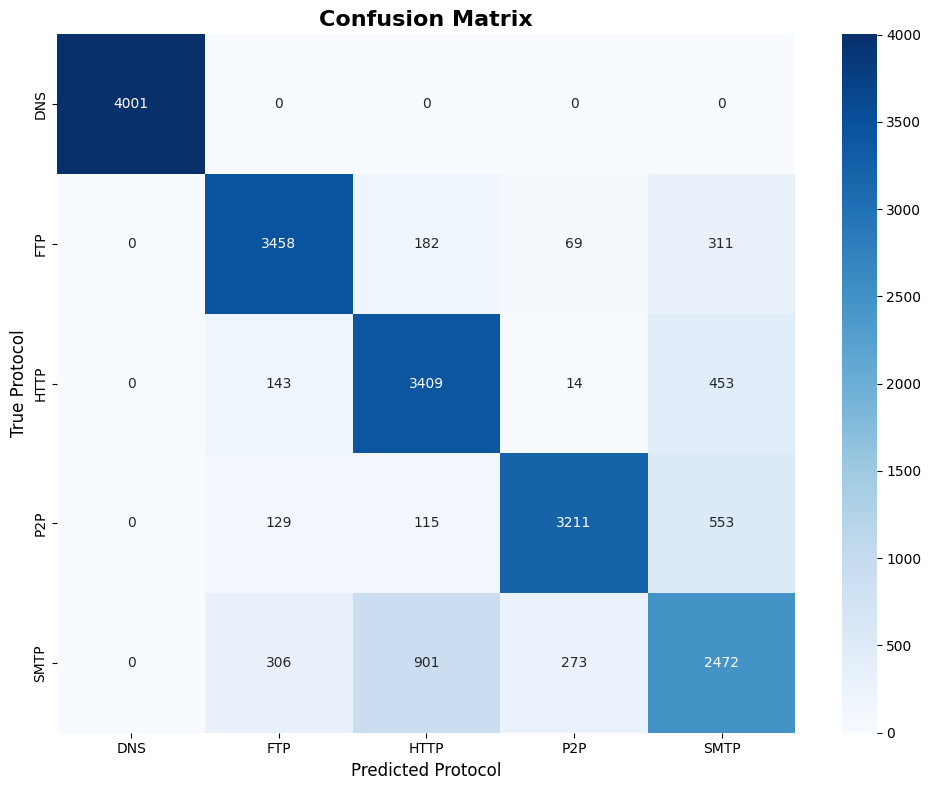

Confusion matrix saved

Feature Importance:
           feature  importance
3  avg_packet_size    0.312609
0         duration    0.248921
1      total_bytes    0.237452
2    total_packets    0.179171
5        byte_rate    0.018877
4      packet_rate    0.002969


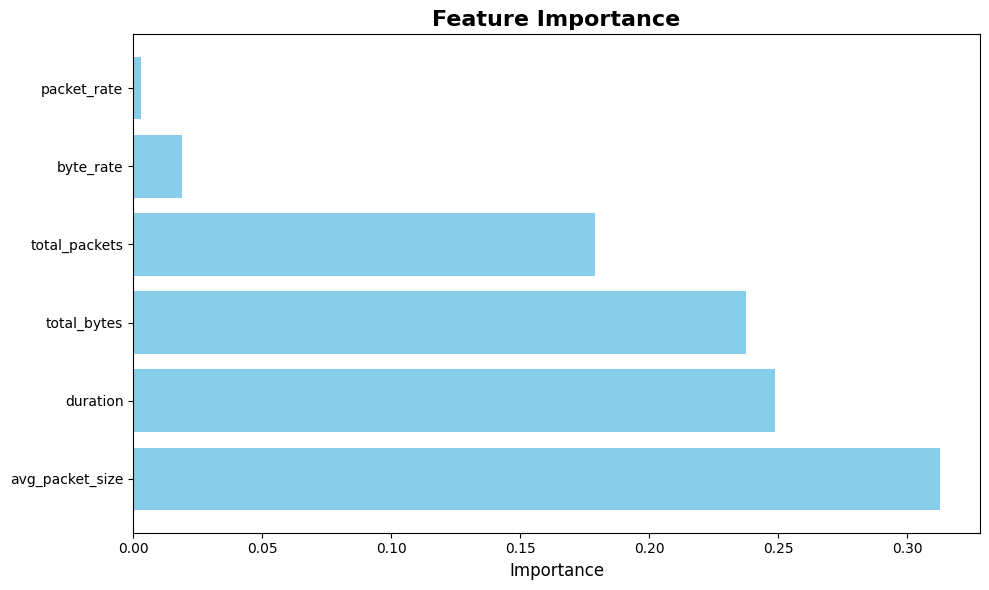

Feature importance saved


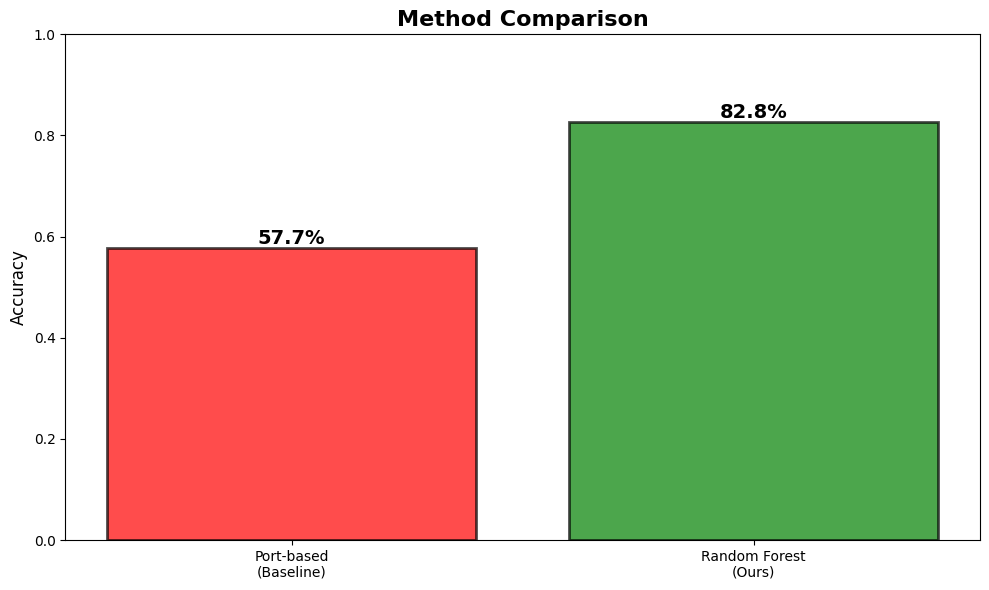

Method comparison saved

Final Results Summary

Method 1 - Port-based classifier:  57.7%
    Features: Only using dst_port (destination port number)
    Problem: Accuracy decreases when protocols use non-standard ports

Method 2 - Random Forest classifier:  82.8%
    Features: Using traffic statistics features (independent of port numbers)
    Advantage: Robust to changes in port numbers

Relative improvement:   43.3%


In [9]:
print("\nStep 2: Loading data...")
df = pd.read_csv('traffic_data.csv')
print(f"Loaded {len(df)} traffic records")
print(f"Protocols: {df['protocol'].unique()}")

print("\nStep 3: Feature engineering...")

# Select features (excluding port numbers!)
feature_cols = [
    'duration',
    'total_bytes',
    'total_packets',
    'avg_packet_size',
    'packet_rate',
    'byte_rate'
]

X = df[feature_cols].fillna(0)
y = df['protocol']

print(f"Feature matrix: {X.shape}")
print(f"Features used: {feature_cols}")

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Protocol mapping:")
for i, protocol in enumerate(le.classes_):
    print(f"   {i} -> {protocol}")

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

import time
start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start

print(f"Training completed in {train_time:.2f}s")

print("\nStep 4: Evaluation...")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"RESULTS")
print(f"Overall Accuracy: {accuracy*100:.2f}%\n")

print("Detailed Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_,
    digits=3
))

print("\nStep 5: Generating visualizations...")

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap='Blues'
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Protocol', fontsize=12)
plt.xlabel('Predicted Protocol', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrix saved")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Feature importance saved")

# Accuracy comparison chart
plt.figure(figsize=(10, 6))
methods = ['Port-based\n(Baseline)', 'Random Forest\n(Ours)']
accuracies = [baseline_accuracy, accuracy]

bars = plt.bar(methods, accuracies, color=['red', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Method Comparison', fontsize=16, fontweight='bold')
plt.ylim([0, 1])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{accuracies[i]*100:.1f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Method comparison saved")

print("\n" + "="*70)
print("Final Results Summary")
print("="*70)

print(f"\nMethod 1 - Port-based classifier:  {baseline_accuracy*100:.1f}%")
print(f"    Features: Only using dst_port (destination port number)")
print(f"    Problem: Accuracy decreases when protocols use non-standard ports")

print(f"\nMethod 2 - Random Forest classifier:  {accuracy*100:.1f}%")
print(f"    Features: Using traffic statistics features (independent of port numbers)")
print(f"    Advantage: Robust to changes in port numbers")

improvement = ((accuracy - baseline_accuracy) / baseline_accuracy) * 100
print(f"\nRelative improvement:   {improvement:.1f}%")


In [10]:
import pickle

model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': feature_cols,
    'accuracy': accuracy
}

with open('protocol_detector.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved: protocol_detector.pkl")
print(f"Model accuracy: {accuracy*100:.2f}%")
print(f"Features: {feature_cols}")

Model saved: protocol_detector.pkl
Model accuracy: 82.75%
Features: ['duration', 'total_bytes', 'total_packets', 'avg_packet_size', 'packet_rate', 'byte_rate']


In [11]:
import pickle
import numpy as np
import pandas as pd

# Load model
with open('protocol_detector.pkl', 'rb') as f:
    model_package = pickle.load(f)

model = model_package['model']
scaler = model_package['scaler']
le = model_package['label_encoder']
feature_names = model_package['feature_names']

print("Model loaded successfully")
print(f"Model accuracy: {model_package['accuracy']*100:.2f}%")

# Test samples
test_samples = [
    # HTTP traffic characteristics
    {
        'duration': 5.0,
        'total_bytes': 50000,
        'total_packets': 80,
        'avg_packet_size': 800,
        'packet_rate': 15,
        'byte_rate': 8000
    },
    # P2P traffic characteristics
    {
        'duration': 120.0,
        'total_bytes': 5000000,
        'total_packets': 5000,
        'avg_packet_size': 1000,
        'packet_rate': 40,
        'byte_rate': 40000
    },
    # DNS traffic characteristics
    {
        'duration': 0.5,
        'total_bytes': 200,
        'total_packets': 2,
        'avg_packet_size': 100,
        'packet_rate': 4,
        'byte_rate': 400
    }
]

print("Testing model with sample data...")

for i, sample in enumerate(test_samples):
    # Extract features
    features = np.array([[sample[f] for f in feature_names]])

    # Standardize
    features_scaled = scaler.transform(features)

    # Predict
    pred = model.predict(features_scaled)[0]
    prob = model.predict_proba(features_scaled)[0]

    protocol = le.inverse_transform([pred])[0]
    confidence = prob[pred]

    print(f"\nSample {i+1}:")
    print(f"  Features: {sample}")
    print(f"  Predicted Protocol: {protocol}")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  All probabilities:")
    for j, p in enumerate(prob):
        print(f"    {le.classes_[j]}: {p*100:.2f}%")

print("Testing complete!")

Model loaded successfully
Model accuracy: 82.75%
Testing model with sample data...

Sample 1:
  Features: {'duration': 5.0, 'total_bytes': 50000, 'total_packets': 80, 'avg_packet_size': 800, 'packet_rate': 15, 'byte_rate': 8000}
  Predicted Protocol: HTTP
  Confidence: 76.53%
  All probabilities:
    DNS: 0.00%
    FTP: 1.53%
    HTTP: 76.53%
    P2P: 1.88%
    SMTP: 20.05%

Sample 2:
  Features: {'duration': 120.0, 'total_bytes': 5000000, 'total_packets': 5000, 'avg_packet_size': 1000, 'packet_rate': 40, 'byte_rate': 40000}
  Predicted Protocol: P2P
  Confidence: 81.33%
  All probabilities:
    DNS: 0.00%
    FTP: 17.67%
    HTTP: 1.00%
    P2P: 81.33%
    SMTP: 0.00%

Sample 3:
  Features: {'duration': 0.5, 'total_bytes': 200, 'total_packets': 2, 'avg_packet_size': 100, 'packet_rate': 4, 'byte_rate': 400}
  Predicted Protocol: DNS
  Confidence: 100.00%
  All probabilities:
    DNS: 100.00%
    FTP: 0.00%
    HTTP: 0.00%
    P2P: 0.00%
    SMTP: 0.00%
Testing complete!


c:\Users\gavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\gavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\gavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
from google.colab import files

files.download('traffic_data.csv')
files.download('protocol_detector.pkl')
files.download('confusion_matrix.png')
files.download('feature_importance.png')
files.download('method_comparison.png')

print("All files downloaded!")

ModuleNotFoundError: No module named 'google.colab'